In [1]:
from pycalphad import Database, Model
import pycalphad.variables as v
from sympy import Symbol, Matrix, hessian

In [2]:
db_rose = Database('bigrose.tdb')
comps = ['H', 'HE', 'LI']#, 'BE', 'B', 'C']#, 'N', 'O', 'F']#, 'NE']
mod = Model(db_rose, comps, 'TEST')
conds = dict()
for comp in comps[:-1]:
    conds[v.X(comp)] = 1/len(comps) 

[TEST0H, TEST0HE, TEST0LI]
fractions:  [ 0.28315075  0.32825621  0.38859303]
potentials:  [[-5595.94571207 -5572.90669674 -5919.92512269]]


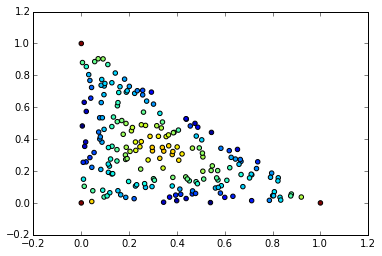

fixed potentials:  [[-5773.505655 -5773.505655 -5773.505655]]
points:  [[ 0.2  0.2  0.6]]


In [3]:
from pycalphad.eq.utils import point_sample, make_callable
from pycalphad.eq.energy_surf import energy_surf
from pycalphad.eq.geometry import lower_convex_hull
import numpy as np
from sympy import Piecewise, lambdify
from sympy.printing.str import StrPrinter
from sympy.utilities.lambdify import lambdastr
variables = list(mod.ast.atoms(v.SiteFraction))
strs = [str(x) for x in variables]
variables = [x for y, x in sorted(zip(strs, variables))]
print(variables)
#sub_dict = dict([(vx, 0.3) for vx in variables])
sub_dict = {v.T: 1000.0}
new_ast = mod.ast.subs(sub_dict)
energy_func = make_callable(new_ast, variables)
gradient_func = make_callable(Matrix([new_ast]).jacobian(variables), variables)
hess_func = make_callable(hessian(new_ast, variables), variables)
df = energy_surf(db_rose, comps, ['TEST'], T=1000.0, pdens=100)
simplices, fractions, potentials = lower_convex_hull(df, comps, conds)
simplices = simplices[0]
fractions = fractions[0]
print('fractions: ', fractions)
print('potentials: ', potentials)
#potentials = potentials[0]
columns = [x for x in sorted(df.columns.values) if x.startswith('Y(')]
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(df[columns].values[:, 0], df[columns].values[:, 1], c=df['GM'].values)
plt.show()
points = df[columns].values[simplices]
potentials[...] = np.array([8.3145*1000*-6.9439E-01])
print('fixed potentials: ', potentials)
points = np.atleast_2d(points[0, :])
#points = np.array([[0.6, 1.24947E-03, 1.24947E-03,
#                   1.24947E-03, 0.1, 1.24947E-03,
#                   1.24947E-03, 1.24947E-03, 1.24947E-03]])
points = np.array([[0.2, 0.2, 0.6]])
print('points: ', points)

In [4]:
# 1. Call energy_surf to sample the entire energy surface at some density (whatever T, P required)
# 2. Call lower_convex_hull to find equilibrium simplices/potentials along the calculation path
# 3. Perform a driving force calculation and discard all points with driving force less than some amount (save memory).
# 4. While any driving force is positive:
#       a. Using the determined potentials for each point on the calculation path, find the constrained minimum
#          for _all_ phases in the system. This will be done with N-R by an iterative calculation.
#       b. If the solver failed to converge, call energy_surf to add more random points for that phase, T, P, etc.
#       c. Add all computed points to the global energy surface calculated by energy_surf.
#       d. Call lower_convex_hull again, including the added points. These should be the equilibrium values.
#       e. Perform a driving force calculation with the new potentials.
# 5. Recompute simplices for points where driving force is zero. This is to catch invariant regions.
# 6. Return the potentials, simplices and fractions found for the calculation path.

for iteration in range(10):
    #print('x: ', points)
    hess = np.rollaxis(hess_func(*points.T), -1)
    print('eigenvalues: ', np.linalg.eigvals(hess))
    gradient = np.squeeze(np.transpose(gradient_func(*points.T), (2, 0, 1)))
    energies = energy_func(*points.T)
    #print('energy: ', energies[..., 0])
    e_matrix = np.linalg.inv(hess)
    e_matrix = e_matrix[0, ...]
    constraint_jac = np.atleast_2d(np.ones(len(comps)))
    # unconstrained Newton-Raphson solution
    dy_unconstrained = -np.dot(e_matrix, gradient)
    # extra terms to handle constraints
    proj_matrix = np.dot(e_matrix, constraint_jac.T)
    inv_term = np.linalg.inv(np.dot(constraint_jac, proj_matrix))
    cons_summation = (points.sum(axis=-1)-1.0) + np.dot(constraint_jac, dy_unconstrained)
    cons_correction = np.dot(proj_matrix, inv_term).dot(cons_summation)
    dy = dy_unconstrained - cons_correction
    driving_force = energies - np.tensordot(points, potentials, axes=(-1, -1))
    print('DF: ', driving_force)
    #diff /= np.linalg.norm(diff, ord=1)
    alpha = 1
    new_points = points+alpha*dy
    new_energies = energy_func(*new_points.T)
    while (new_energies > energies - 0.1*np.dot(dy.T, gradient)) or np.any(new_points < 0):
        alpha *= 0.5
        new_points = points+alpha*dy
        new_energies = energy_func(*new_points.T)
        if alpha < 1e-6:
            break
    points = new_points
    if np.linalg.norm(alpha*dy) < 1e-12:
        break
    #if np.any(points < 0):
    #    points -= alpha*dy
    #    break
    #print('diff ', diff)
    #print('sum ', diff.sum(axis=-1))
    #print('new x = ', points)
print('iterations: ', iteration)
print('x: ', points)
print('alpha: ', alpha)
print('gradient: ', gradient)

print('potentials: ', potentials)
print('x_sum_residual: ', 1 - points.sum(axis=-1))
print('energy: ', energies[..., 0])
print('dy ', dy)

eigenvalues:  [[ 180746.87790349  -78427.5          -5316.87790349]]
DF:  [[ 2672.48125655]]
eigenvalues:  [[ 269426.47788674  -66455.03246689    7851.06004021]]
DF:  [[ 2231.48176673]]
eigenvalues:  [[ 232599.75526182  -81319.28935312    6116.21212965]]
DF:  [[ 2003.60227193]]
eigenvalues:  [[ 226909.42375115  -82654.58949071    5625.68986006]]
DF:  [[ 1997.19735541]]
eigenvalues:  [[ 226704.59855722  -82696.89488387    5606.31914167]]
DF:  [[ 1997.18913126]]
eigenvalues:  [[ 226704.3166155   -82696.9528339     5606.29239003]]
DF:  [[ 1997.18913125]]
eigenvalues:  [[ 226704.31661497  -82696.95283401    5606.29238998]]
DF:  [[ 1997.18913125]]
iterations:  6
x:  [[ 0.11991257  0.11991257  0.76017487]]
alpha:  1
gradient:  [ 8910.41241271  8910.41241271  8910.41241271]
potentials:  [[-5773.505655 -5773.505655 -5773.505655]]
x_sum_residual:  [  1.11022302e-16]
energy:  -3776.3165237530875
dy  [ -2.77555756e-17  -1.38777878e-17   0.00000000e+00]


In [53]:
energy_func(*[4.99371E-01,4.99371E-01,1.25861E-03])

-5773.4836631494927